# This notebook shows statistics for the space missions launched since the beginning of the space race.

The data for the statistical analysis was drawn from https://www.kaggle.com/datasets/salmane/space-missions-launches


The rows of the cvs data include the country of launching, the date, the success status, the company/organization, the price of the mission, the vessel model and the rocket status.

The data analysis will focus on:

1) Percentage of launchings by country with respect to the total number of launchings. 
2) Timeline of total launchings and discriminated by country (cumulative). 
3) Success rate discriminated by country. Timeline of success rate.
4) Cummulative money invested by country.
5) For each country, percentaje of launchings by organizations/companies.

## Inicialization

#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Define graphic style

In [126]:
sns.set_style("darkgrid")
color_palette = sns.color_palette('magma_r',n_colors=12)[1:]
bar_color = color_palette[4]
bar_text = color_palette[7]

## Handle Data

#### Read Data

In [2]:
data = pd.read_csv("/home/palas/Documents/Data_sets/mission_launches.csv")

In [3]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Organisation', 'Location', 'Date',
       'Detail', 'Rocket_Status', 'Price', 'Mission_Status'],
      dtype='object')

#### Remove commas from data and convert to float when neccessary:

In [4]:
data['Price'] = data['Price'].str.replace(',','').astype(float)

#### Obtain the location of the launching

In [6]:
data['country'] = data['Location'].str.split(',').str[-1].str.strip()


#### Separate the data by location

In [162]:
# Ignore the warning for making a pandas column substitution
import warnings
warnings.filterwarnings("ignore")

location_dict = {}
for location in data['country'].unique():
    # Create a dataframe subset for each location
    subset = data[data['country'] == location]
    
    # Add the subset dataframe to the dictionary
    location_dict[location] = subset
    
    location_dict[location].loc[:, 'Date'] = pd.to_datetime(location_dict[location]['Date'], format='mixed',utc=True)
    location_dict[location].loc[:, 'Date'] = pd.to_datetime(location_dict[location]['Date'], format='%Y-%m-%d')

    #Invert the order of the data frame so dates are rising:
    location_dict[location] = location_dict[location].iloc[::-1]
    
    # Calculate the cumulative number of launches
    cumulative=[]
    for i in range(len(location_dict[location])):
        cumulative.append(i+1)
    location_dict[location].loc[:,'cumulative'] = cumulative     
   

## Percentaje of launchs by country with respect to total

#### Calculate the percentage of launchs for each country with respect to the total launchs

In [13]:
total_number_launches = len(data)

launches_by_country = pd.DataFrame()
number_launches = []
country_percentage = []

for location in location_dict:
    number_launches_ = len(location_dict[location])
    country_percentage_ = number_launches_*100/total_number_launches
    number_launches.append(number_launches_)
    country_percentage.append(country_percentage_)
    
launches_by_country['location'] = data['country'].unique()
launches_by_country['number_launches'] = number_launches
launches_by_country['percentage'] = country_percentage

#### Compact locations with less than 1% of launchings in "others" categroy

In [15]:
# Filter the dataframe to keep only the locations with at least 1% of events

high_launches_cuntries = launches_by_country[launches_by_country['percentage'] >= 1]


# Create a new row for the "others" category
others_df = launches_by_country[launches_by_country['percentage'] < 1]
others_sum = others_df['number_launches'].sum()
others_percentage = others_df['percentage'].sum()
others_row = pd.DataFrame({'location': ['others'], 'number_launches': [others_sum], 'percentage': [others_percentage]})

# Append the "others" row to the filtered dataframe
result_df = pd.concat([high_launches_cuntries, others_row])

# Sort the resulting dataframe by percentage in descending order
new_launches_by_country = result_df.sort_values('percentage', ascending=False)

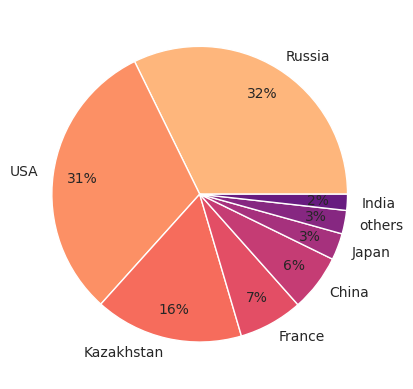

In [108]:
colors = sns.color_palette('magma_r',n_colors=12)[1:]

plt.pie(
    new_launches_by_country['percentage'], 
    labels=new_launches_by_country['location'],
    colors = colors, 
    autopct='%.0f%%', 
    pctdistance=0.8, 
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    );


## Timeline of total launchings and discriminated by country
(only countries that have contributed with more than 1% of total launches)

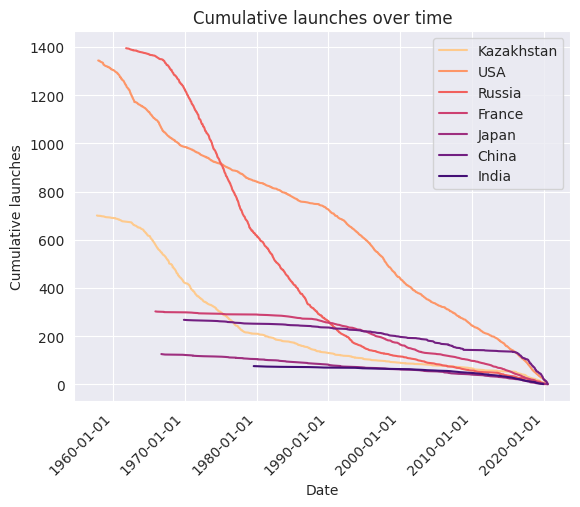

In [163]:
from datetime import datetime
import matplotlib.dates as mdates

locations = data['country'].unique()

# Convert date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'],format='mixed',utc=True)

# Sort data by date
#data = data.sort_values(by=['Date'])

colors = sns.color_palette('magma_r',n_colors=8)[0:]
sns.set_palette(colors)

# Plot each timeline separately
for location in locations:
    loc_data = data[data['country'] == location]
    if (len(location_dict[location]['cumulative'])*100/total_number_launches >= 1):
        sns.lineplot(x=loc_data['Date'], y=location_dict[location]['cumulative'],label=location)     

# Format x-axis tick labels
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("Cumulative launches over time")

# Add legend and axis labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative launches');

## Now counties that have contribuited with less than 1% of the total launches

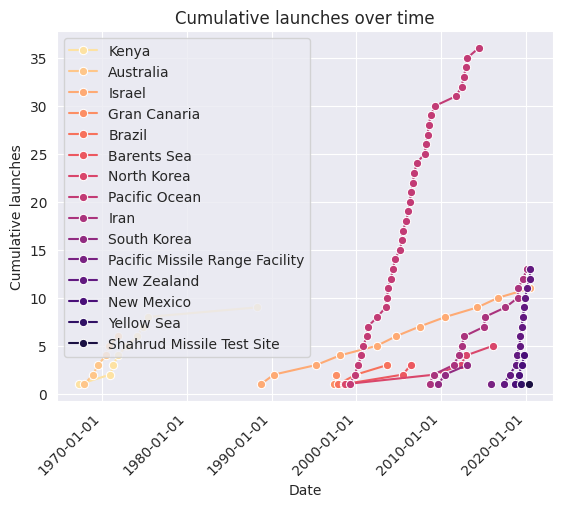

In [160]:
# Convert date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'],format='mixed',utc=True)

# Sort data by date
data = data.sort_values(by=['Date'])

colors = sns.color_palette('magma_r',n_colors=16)[0:]
sns.set_palette(colors)

# Plot each timeline separately
for location in locations:
    loc_data = data[data['country'] == location]
    if (len(location_dict[location]['cumulative'])*100/total_number_launches < 1):
        sns.lineplot(x=loc_data['Date'], y=location_dict[location]['cumulative'], label=location, marker="o")

# Format x-axis tick labels
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("Cumulative launches over time")

# Add legend and axis labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative launches');

# Calculate the success rate!
By country and total

In [58]:
#by country

rate = pd.DataFrame(columns=['location','status'])
for location in locations:
    success = 0
    failure = 0
    for i, status in enumerate(location_dict[location]['Mission_Status']): 
        if (status=='Success'): success = success + 1
        if (status=='Failure'): failure = failure + 1    
    if (failure != len(location_dict[location]['Mission_Status'])):
        success_rate = success/len(location_dict[location]['Mission_Status'])
    #Add locations with success rate=0
    if (failure == len(location_dict[location]['Mission_Status'])):
        success_rate = 0
                
    rate.loc[i] = [location, success_rate]

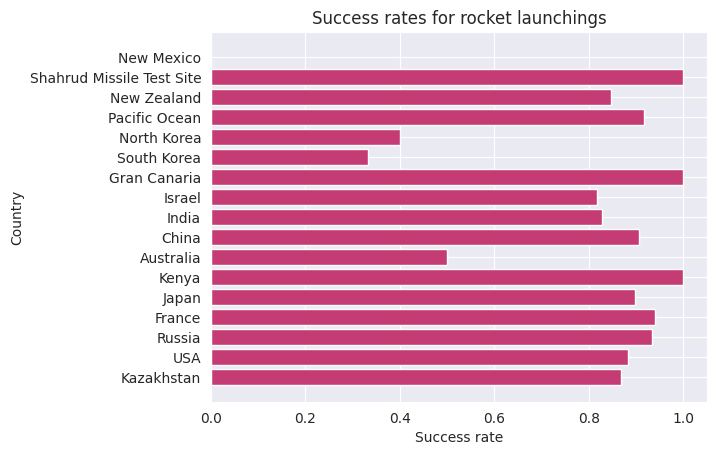

In [159]:
# Create horizontal bar plot
fig, ax = plt.subplots()
ax.barh(rate.location, rate.status, color= bar_plots_color)

# Set axis labels and title
ax.set_xlabel('Success rate')
ax.set_ylabel('Country')
ax.set_title('Success rates for rocket launchings');

#### Success rate over time

In [71]:

for location in locations:
    success = 0
    success_cum = []
    failure_cum = []
    for i, status in enumerate(location_dict[location]['Mission_Status']): 
        if (status=='Success'): success = success + 1
        if (status=='Failure'): failure = failure + 1    
        success_rate_cum = success/location_dict[location].reset_index().iloc()[i]['cumulative']
        success_cum.append(success_rate_cum)
    location_dict[location]['cum_success'] = success_cum


## Timeline of cummulative success discriminated by country
(only countries that have contributed with more than 1% of total launches)

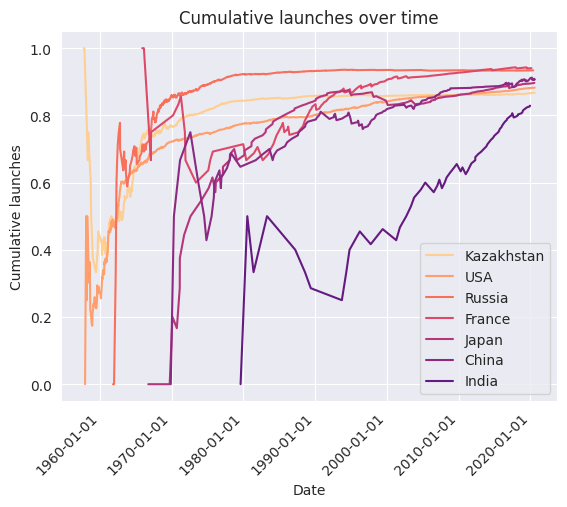

In [158]:
from datetime import datetime
import matplotlib.dates as mdates

locations = data['country'].unique()

# Convert date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'],format='mixed',utc=True)

# Sort data by date
#data = data.sort_values(by=['Date'])

colors = sns.color_palette('magma_r',n_colors=9)[0:]
sns.set_palette(colors)

# Plot each timeline separately
for location in locations:
    loc_data = data[data['country'] == location]
    if (len(location_dict[location]['cumulative'])*100/total_number_launches >= 1):
        sns.lineplot(x=loc_data['Date'], y=location_dict[location]['cum_success'], label=location)     

# Format x-axis tick labels
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("Cumulative launches over time")

# Add legend and axis labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative launches');

## Now counties that have contribuited with less than 1% of the total launches

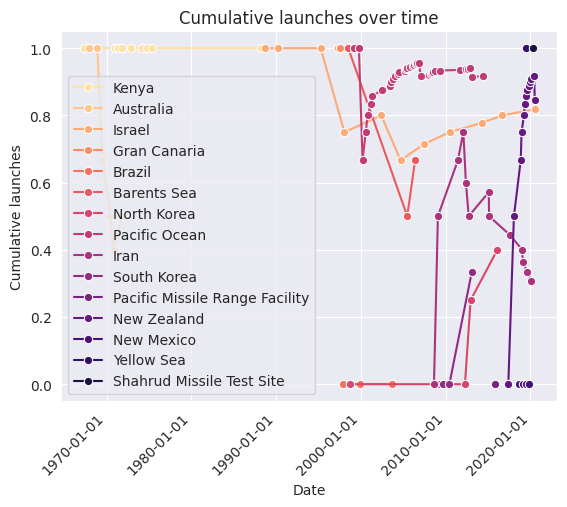

In [157]:
# Convert date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'],format='mixed',utc=True)

# Sort data by date
data = data.sort_values(by=['Date'])

colors = sns.color_palette('magma_r',n_colors=16)[0:]
sns.set_palette(colors)

# Plot each timeline separately
for location in locations:
    loc_data = data[data['country'] == location]
    if (len(location_dict[location]['cumulative'])*100/total_number_launches < 1):
        sns.lineplot(x=loc_data['Date'], y=location_dict[location]['cum_success'], label=location, marker="o")

# Format x-axis tick labels
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("Cumulative launches over time")

# Add legend and axis labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative launches');

## Cumulative investment over time

Each cuntry has reported some of the mission prices but non has completely reported.
The idea here is to find out the percentaje of reported costs for each country and find out the media and deviation of the reported costs. I think maybe box plots are the best approach for this information.Maybe adding some bar that indicates the total ammount of missions to show the unreported prices. Or maybe a bar plot is better to show the percentaje of reported prices respect to the total amount of missions.

In [87]:
import math
for location in locations:
    price_ind = 0
    price_cum = []
    price_cum_ = 0
    for i, reported_price in enumerate(location_dict[location]['Price']): 
        if not math.isnan(reported_price):
            price_cum_ = price_cum_ + reported_price
        if math.isnan(reported_price):
            price_cum_ = price_cum_ 
        price_cum.append(price_cum_)
    
    location_dict[location]['cum_price'] = price_cum

The following plot is not really the cummulative costs of missions by country since the database is not complete regarding the prices reported by each country. Instead, the plot kind of shows the completeness of the database regarding the prices. The plot below this shows the percentaje of the price repored respect to the reported missions. 

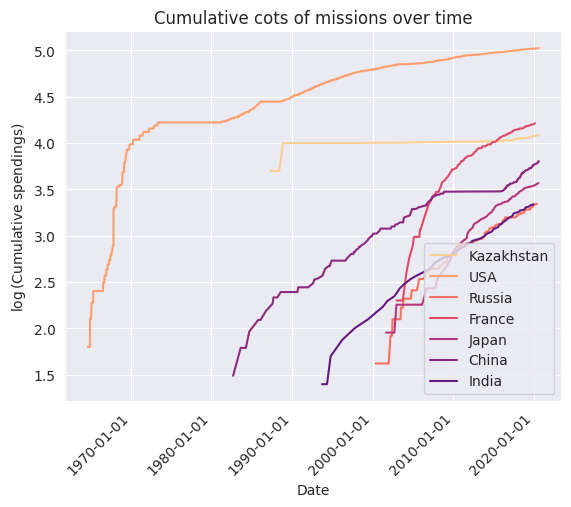

In [156]:
# Convert date strings to datetime objects
data['Date'] = pd.to_datetime(data['Date'],format='mixed',utc=True)

# Sort data by date
#data = data.sort_values(by=['Date'])

colors = sns.color_palette('magma_r',n_colors=9)[0:]
sns.set_palette(colors)

# Plot each timeline separately
for location in locations:
    loc_data = data[data['country'] == location]
    if (len(location_dict[location]['cumulative'])*100/total_number_launches >= 1):
        sns.lineplot(x=loc_data['Date'], y=np.log10(location_dict[location]['cum_price']), label=location)  

# Format x-axis tick labels
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("Cumulative cots of missions over time")

# Add legend and axis labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('$\log$(Cumulative spendings)');

## Percentaje of missions with reported costs with respect to the number of missions by country

In [90]:
#by country

price = pd.DataFrame(columns=['location','total_cost','percentaje_reported'])
price_sum = []
percentaje = []
for location in locations:
    price_sum_ = location_dict[location]['Price'].dropna().sum()
    percentaje_ = len(location_dict[location]['Price'].dropna())/len(location_dict[location]['Price'])

    price_sum.append(price_sum_)
    percentaje.append(percentaje_)
                
price.location = locations
price.total_cost = price_sum
price.percentaje_reported = percentaje



Text(0.5, 1.0, 'Percentaje of cost reported')

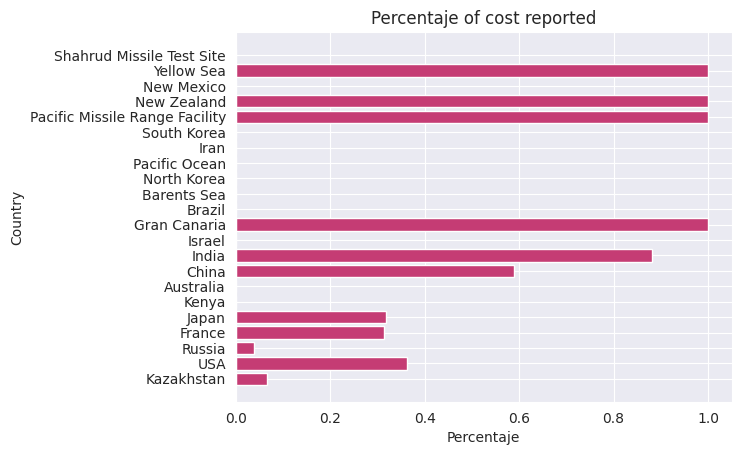

In [116]:
# Create horizontal bar plot
fig, ax = plt.subplots()
ax.barh(price.location, price.percentaje_reported, color= bar_plots_color)

# Set axis labels and title
ax.set_xlabel('Percentaje')
ax.set_ylabel('Country')
ax.set_title('Percentaje of cost reported')

## Detail of the organizations that performed the launching by country:

In [117]:
# Determine the percentaje of launching for each organization

org_dict = {}
for location in locations:
    org_counts = location_dict[location]['Organisation'].value_counts()
    percentaje_org = []
    for i, counts in enumerate(org_counts):
        percentaje = org_counts[i]/len(location_dict[location]['Organisation'])
        percentaje_org.append(percentaje)
        #print(org_counts.index[i])
        #print(location)

    org_data = pd.DataFrame({'organisation':org_counts.index,
                             'count':org_counts,
                             'percentaje':percentaje_org})
    
    
    org_dict[location] = org_data
        

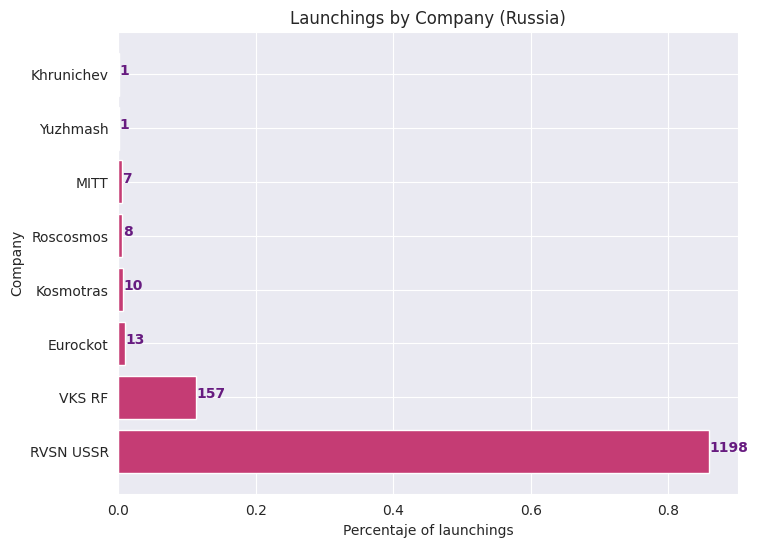

In [130]:
# Plot the percentaje an total ammount of launchings for each company for Russia:

country='Russia'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(org_dict[country]['organisation'], org_dict[country]['percentaje'], color= bar_color)
ax.set_xlabel('Percentaje of launchings')
ax.set_ylabel('Company')
ax.set_title('Launchings by Company (Russia)')

for i, v in enumerate(org_dict[country]['percentaje']):
    text = str(org_dict[country]['count'][i])
    ax.text(v + 0.0005, i, text, color=bar_text, fontweight='bold')

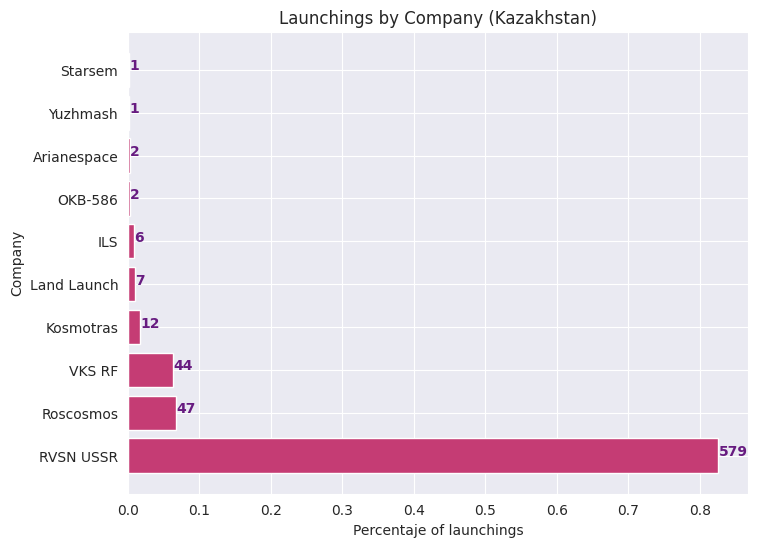

In [143]:
# Plot the percentaje an total ammount of launchings for each company 

country='Kazakhstan'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(org_dict[country]['organisation'], org_dict[country]['percentaje'], color= bar_color)
ax.set_xlabel('Percentaje of launchings')
ax.set_ylabel('Company')
ax.set_title(f'Launchings by Company ({country})')

for i, v in enumerate(org_dict[country]['percentaje']):
    text = str(org_dict[country]['count'][i])
    ax.text(v + 0.0005, i, text, color=bar_text, fontweight='bold')

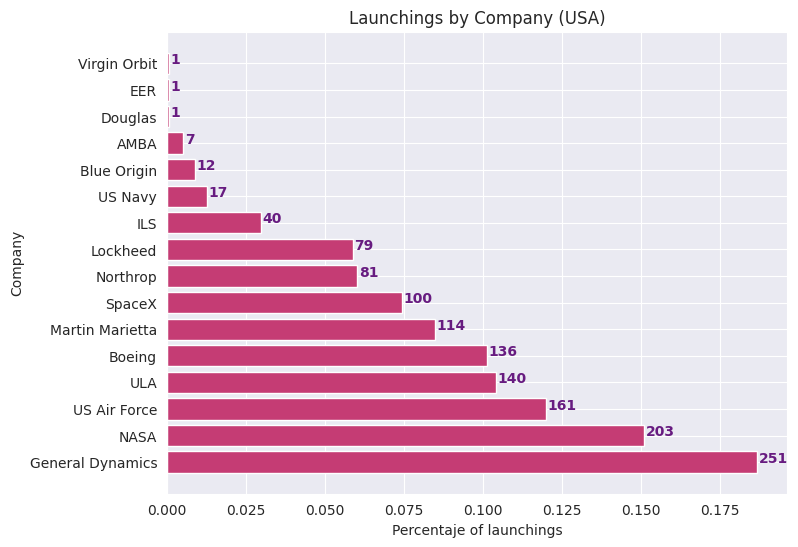

In [145]:
# Plot the percentaje an total ammount of launchings for each company for USA:

country='USA'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(org_dict[country]['organisation'], org_dict[country]['percentaje'], color=bar_color)
ax.set_xlabel('Percentaje of launchings')
ax.set_ylabel('Company')
ax.set_title(f'Launchings by Company ({country})')

for i, v in enumerate(org_dict[country]['percentaje']):
    text = str(org_dict[country]['count'][i])
    ax.text(v + 0.0005, i, text, color=bar_text, fontweight='bold')

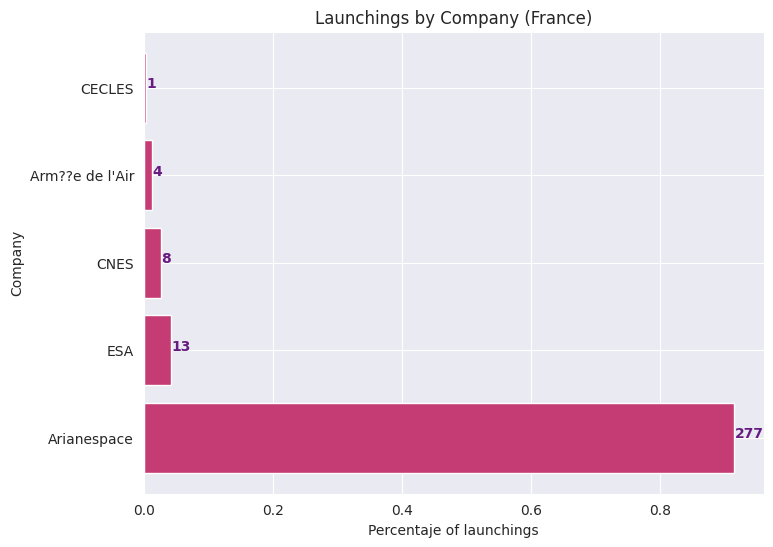

In [141]:
# Plot the percentaje an total ammount of launchings for each company 

country='France'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(org_dict[country]['organisation'], org_dict[country]['percentaje'], color= bar_color)
ax.set_xlabel('Percentaje of launchings')
ax.set_ylabel('Company')
ax.set_title(f'Launchings by Company ({country})')

for i, v in enumerate(org_dict[country]['percentaje']):
    text = str(org_dict[country]['count'][i])
    ax.text(v + 0.0005, i, text, color=bar_text, fontweight='bold')

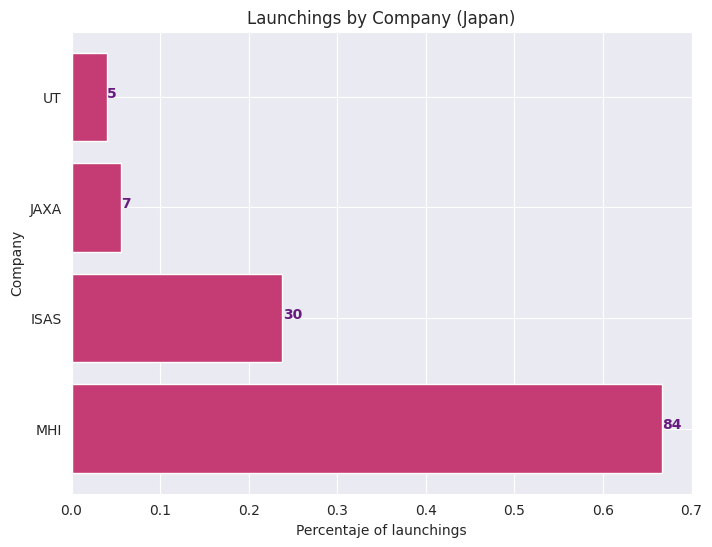

In [140]:
# Plot the percentaje an total ammount of launchings for each company 

country='Japan'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(org_dict[country]['organisation'], org_dict[country]['percentaje'], color= bar_color)
ax.set_xlabel('Percentaje of launchings')
ax.set_ylabel('Company')
ax.set_title(f'Launchings by Company ({country})')

for i, v in enumerate(org_dict[country]['percentaje']):
    text = str(org_dict[country]['count'][i])
    ax.text(v + 0.0005, i, text, color=bar_text, fontweight='bold')

Next:

- Make the plots better with seaborn.
- Upload the results to a server (Flask + Plotly) 
- Writte summary and description of the launching sites.
